## Import libraries

In [1]:
import lib
import scipy.optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read data

In [2]:
data_fpg_cps = pd.read_csv('orginal-data/data_fpg_cps.csv', 
                           index_col='channel')
display(data_fpg_cps.info())
display(data_fpg_cps.describe())
display(data_fpg_cps.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 190
Data columns (total 7 columns):
background     191 non-null float64
Co60_100cm     191 non-null float64
Co60_200cm     191 non-null float64
Co57_53cm      191 non-null float64
Co57_30cm      191 non-null float64
Cs137_100cm    191 non-null float64
Cs137_200cm    191 non-null float64
dtypes: float64(7)
memory usage: 11.9 KB


None

,background,Co60_100cm,Co60_200cm,Co57_53cm,Co57_30cm,Cs137_100cm,Cs137_200cm
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,1.484572,7.733711,3.320332,3.998447,8.579023,13.536126,5.016230
std,1.301703,7.072485,3.066959,5.174157,13.259709,13.284134,4.812517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.213333,0.563889,0.319444,0.235000,0.278333,0.275000,0.255556
50%,1.146667,8.255556,3.166667,1.730000,1.916667,9.138889,3.022222
75%,2.450000,10.630556,5.147222,5.816667,10.290000,25.411111,9.352778
max,4.056667,22.822222,9.838889,17.710000,45.060000,36.872222,13.844444


,background,Co60_100cm,Co60_200cm,Co57_53cm,Co57_30cm,Cs137_100cm,Cs137_200cm
channel,,,,,,,
0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.00,0.005556,0.000000
3,0.0,0.005556,0.005556,0.020000,0.02,0.011111,0.000000
4,0.0,0.022222,0.000000,0.043333,0.13,0.044444,0.027778


In [3]:
calib_data_fpg_meas = pd.read_excel('orginal-data/MeasurementforCalibration_FPG.xlsx', 
                                    sheet_name='Measurements', 
                                    index_col='Measurement',
                                    skiprows=5)

calib_data_fpg_meas.fillna(method='ffill', axis=0, inplace = True)
calib_data_fpg_meas.replace('-', np.nan, inplace=True)
calib_data_fpg_meas['Front Contrib'] = calib_data_fpg_meas['Front Contrib'] * 100
calib_data_fpg_meas['Efficiency'] = calib_data_fpg_meas['Efficiency'] * 100

calib_data_fpg_meas.rename(columns={'Distance [cm]': 'Distance_cm',
                                    'Activity [kBq]': 'Activity_kBq',
                                    'Front [cps]': 'Front_cps',
                                    'Back [cps]': 'Back_cps',
                                    'Total [cps]': 'Total_cps',
                                    'Net [cps]': 'Net_cps',
                                    'Front Contrib': 'FrontContrib_pc',
                                    'Theor. Dose Rate [uSv/h]': 'TheorDoseRate_uSvh',
                                    'Efficiency': 'Efficiency_pc'},
                           inplace=True)

calib_data_fpg_meas.replace(to_replace = 'theoretical bkg around 30-50 nSv/h', value = 0.04, inplace = True, regex=True) # the mean value = 40 nSv/h
calib_data_fpg_meas['TheorDoseRate_uSvh'].astype(float, inplace=True)

display(calib_data_fpg_meas.head())
display(calib_data_fpg_meas.info())
display(calib_data_fpg_meas.describe())

,Source,Distance_cm,Activity_kBq,Front_cps,Back_cps,Total_cps,Net_cps,FrontContrib_pc,Efficiency_pc,TheorDoseRate_uSvh
Measurement,,,,,,,,,,
1,Background,30 from ground,NaN,75.55,209.51,285.06,NaN,26.503192,NaN,0.040000
2,Background-v,87 from ground,NaN,77.70,222.02,299.72,NaN,25.924196,NaN,0.040000
3,Am-241,30,2343.666131,146.68,589.21,735.89,450.83,15.777566,1.954979,0.103094
4,Am-241,53,2343.666131,100.89,349.68,450.57,165.51,15.310253,1.954979,0.032944
5,Am-241-v,100,2343.666131,86.86,263.61,350.47,50.75,18.049261,1.954979,0.009204


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 1 to 15
Data columns (total 10 columns):
Source                14 non-null object
Distance_cm           14 non-null object
Activity_kBq          12 non-null float64
Front_cps             14 non-null float64
Back_cps              14 non-null float64
Total_cps             14 non-null float64
Net_cps               12 non-null float64
FrontContrib_pc       14 non-null float64
Efficiency_pc         12 non-null float64
TheorDoseRate_uSvh    14 non-null float64
dtypes: float64(8), object(2)
memory usage: 1.2+ KB


None

,Activity_kBq,Front_cps,Back_cps,Total_cps,Net_cps,FrontContrib_pc,Efficiency_pc,TheorDoseRate_uSvh
count,12.000000,14.000000,14.00000,14.000000,12.000000,14.000000,12.000000,14.000000
mean,1418.670208,219.890000,735.55500,955.445000,773.564167,21.354191,16.311500,0.079736
std,1115.118731,168.381797,533.66091,692.083899,687.546033,5.777527,14.436775,0.068053
min,243.870062,75.550000,209.51000,285.060000,50.750000,11.242345,1.954979,0.009204
25%,510.257779,103.120000,330.95250,438.532500,293.872500,16.345490,3.926199,0.040000
50%,991.000000,157.290000,612.40500,750.505000,532.905000,24.057611,13.816424,0.046106
75%,2343.666131,234.970000,991.56500,1349.457500,1223.870000,25.575598,33.148393,0.122074
max,3040.663271,637.410000,1949.87000,2587.280000,2287.560000,27.166135,36.480231,0.231455


In [4]:
calib_data_sources = pd.read_excel('orginal-data/MeasurementforCalibration_FPG.xlsx', 
                                    sheet_name='Sources', 
                                    skiprows=2)

calib_data_sources.index.name = 'Measurement'
calib_data_sources.fillna(method='ffill', axis=0, inplace = True)

chars = "[]" 
for char in chars:
    converter = lambda x: x.replace(char, '')
    calib_data_sources.columns = list(map(converter, calib_data_sources.columns))
    
converter = lambda x: x.replace(' ', '_')
calib_data_sources.columns = list(map(converter,calib_data_sources.columns))

calib_data_sources.rename(columns={'Emitted_s-1': 'Emitted_s1'}, inplace=True)

display(calib_data_sources.head())
display(calib_data_sources.info())
display(calib_data_sources.describe())

,SOURCE,Date,Activity_kBq,Energy_keV,Emission_prob,Emitted_s1,Gamma_at_200_cm,Gamma_at_120_cm,Gamma_at_100cm,Gamma_at_53cm,Gamma_at_30_cm,Incident_at_200_cm,Incident_at_120_cm,Incident_at_100_cm,Incident_at_53cm,Incident_at_30cm,Average_Emission_Energy_keV
Measurement,,,,,,,,,,,,,,,,,
0,Am-241,2021-09-17,2343.666131,59.5400,0.3592,841844.874375,1.674797,4.652214,6.699189,23.849016,74.435429,648.983901,1802.733058,2595.935603,9241.493782,28843.728926,59.540000
1,Co-57,2021-09-17,991.000000,122.1000,0.8560,848296.000000,1.687631,4.687865,6.750525,24.031773,75.005834,653.957117,1816.547548,2615.828469,9312.312099,29064.760762,123.697341
2,Co-57,2021-09-17,991.000000,136.5000,0.1068,105838.800000,0.210560,0.584888,0.842238,2.998357,9.358205,81.591846,226.644016,326.367384,1161.863239,3626.304263,123.697341
3,Ba-133,2021-09-17,243.870062,80.9979,0.3331,81233.117762,0.161608,0.448912,0.646433,2.301291,7.182585,62.623159,173.953220,250.492637,891.750221,2783.251523,275.444492
4,Ba-133,2021-09-17,243.870062,276.3989,0.0713,17387.935444,0.034592,0.096089,0.138369,0.492591,1.537431,13.404477,37.234658,53.617908,190.878988,595.754529,275.444492


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 17 columns):
SOURCE                         11 non-null object
Date                           11 non-null datetime64[ns]
Activity_kBq                   11 non-null float64
Energy_keV                     11 non-null float64
Emission_prob                  11 non-null float64
Emitted_s1                     11 non-null float64
Gamma_at_200_cm                11 non-null float64
Gamma_at_120_cm                11 non-null float64
Gamma_at_100cm                 11 non-null float64
Gamma_at_53cm                  11 non-null float64
Gamma_at_30_cm                 11 non-null float64
Incident_at_200_cm             11 non-null float64
Incident_at_120_cm             11 non-null float64
Incident_at_100_cm             11 non-null float64
Incident_at_53cm               11 non-null float64
Incident_at_30cm               11 non-null float64
Average_Emission_Energy_keV    11 non-null float64
dtypes: datetime64[ns](1

None

,Activity_kBq,Energy_keV,Emission_prob,Emitted_s1,Gamma_at_200_cm,Gamma_at_120_cm,Gamma_at_100cm,Gamma_at_53cm,Gamma_at_30_cm,Incident_at_200_cm,Incident_at_120_cm,Incident_at_100_cm,Incident_at_53cm,Incident_at_30cm,Average_Emission_Energy_keV
count,11.000000,11.000000,11.000000,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,889.435189,444.147818,0.497057,5.357946e+05,1.065930,2.960915,4.263718,15.178776,47.374647,413.047702,1147.354728,1652.190808,5881.775750,18357.675646,441.058166
std,949.505936,436.542652,0.376432,7.555708e+05,1.503160,4.175446,6.012642,21.404918,66.807129,582.474653,1617.985148,2329.898613,8294.405885,25887.762367,430.233798
min,243.870062,59.540000,0.071300,1.738794e+04,0.034592,0.096089,0.138369,0.492591,1.537431,13.404477,37.234658,53.617908,190.878988,595.754529,59.540000
25%,243.870062,129.300000,0.144950,6.294286e+04,0.125221,0.347836,0.500883,1.783138,5.565371,48.523078,134.786329,194.092313,690.965872,2156.581261,199.570917
50%,599.053685,302.850800,0.359200,1.513214e+05,0.301044,0.836234,1.204177,4.286854,13.379747,116.654669,324.040748,466.618677,1661.155845,5184.651966,275.444492
75%,991.000000,522.752750,0.852950,7.203972e+05,1.433185,3.981068,5.732738,20.408467,63.697094,555.359039,1542.663997,2221.436155,7908.281080,24682.623947,468.550746
max,3040.663271,1332.492000,0.999826,2.584260e+06,5.141221,14.281170,20.564885,73.210699,228.498727,1992.223272,5533.953533,7968.893087,28369.145913,88543.256522,1252.912840


## Visualize and check data

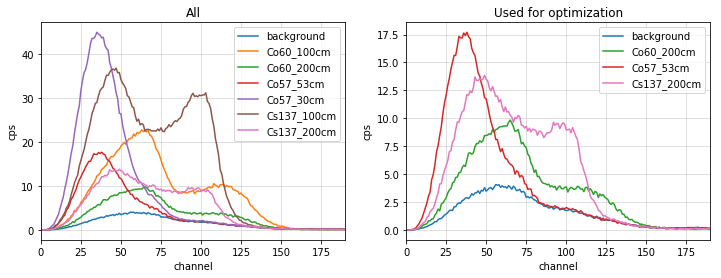

In [5]:
%matplotlib inline

fig, axes = plt.subplots(ncols = 2, figsize = (12, 4))

axes[0].set_title('All')
data_fpg_cps.plot(ax = axes[0])

axes[1].set_title('Used for optimization')
data_fpg_cps.background.plot(ax = axes[1], color = 'C0')
data_fpg_cps.Co60_200cm.plot(ax = axes[1], color = 'C2')
data_fpg_cps.Co57_53cm.plot(ax = axes[1], color = 'C3')
data_fpg_cps.Cs137_200cm.plot(ax = axes[1], color = 'C6')

for ax in axes:
    ax.grid(alpha = 0.5)
    ax.legend()
    ax.set_ylabel('cps')

plt.savefig('ToT_hists.pdf', bbox_inches='tight')

## Subtract the background signal


In [6]:
for col in data_fpg_cps.columns[1:]:
    data_fpg_cps[col] = data_fpg_cps[col] - data_fpg_cps['background'] 

## Optimize and check results

### For a linear function and all available data

In [7]:
spectra = ['Co60_100cm', 'Co60_200cm', 'Co57_53cm', 'Co57_30cm', 'Cs137_100cm', 'Cs137_200cm']
x0 = [0, 0]

opti_results = scipy.optimize.least_squares(lib.make_loss_fun(data_fpg_cps, calib_data_fpg_meas, spectra, lib.lin_fun), x0)
acc_list = lib.compute_accuracy(data_fpg_cps, calib_data_fpg_meas, spectra, opti_results, lib.lin_fun)

lib.print_results(spectra, opti_results, acc_list)

Optimizaton results:
  active_mask: array([0., 0.])
        cost: 1.8004954513234145e-05
         fun: array([0.00600083])
        grad: array([ 2.06361468, -0.40454183])
         jac: array([[343.88845546, -67.41436065]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 30
        njev: 6
  optimality: 2.0636146798959785
      status: 3
     success: True
           x: array([1.71336120e-06, 3.07810948e-08])

measurement	accuracy [%]
Co60_100cm	 82.06
Co60_200cm	 92.96
Co57_53cm	 67.60
Co57_30cm	 61.06
Cs137_100cm	 85.29
Cs137_200cm	 68.81

Mean accuracy [%]: 76.30


### For a linear function and data suggested by the authors

In [8]:
spectra = ['Co60_200cm', 'Co57_53cm', 'Cs137_200cm'] 

opti_results = scipy.optimize.least_squares(lib.make_loss_fun(data_fpg_cps, calib_data_fpg_meas, spectra, lib.lin_fun), x0)
acc_list = lib.compute_accuracy(data_fpg_cps, calib_data_fpg_meas, spectra, opti_results, lib.lin_fun)

lib.print_results(spectra, opti_results, acc_list)

Optimizaton results:
  active_mask: array([0., 0.])
        cost: 1.2218616010847626e-07
         fun: array([0.00049434])
        grad: array([ 0.02014889, -0.00333873])
         jac: array([[40.75915429, -6.75391443]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 32
        njev: 8
  optimality: 0.020148892064553968
      status: 3
     success: True
           x: array([1.56205234e-06, 3.53458650e-08])

measurement	accuracy [%]
Co60_200cm	 84.75
Co57_53cm	 61.64
Cs137_200cm	 80.39

Mean accuracy [%]: 75.60


### For a logarithmic function and all available data

In [9]:
spectra = ['Co60_100cm', 'Co60_200cm', 'Co57_53cm', 'Co57_30cm', 'Cs137_100cm', 'Cs137_200cm']
bounds = np.array([[0, -100, -100],  [100, 0, 100]]) # a has to be > 0 and b has to be < 0 according to the fig. 5 (https://arxiv.org/ftp/arxiv/papers/2112/2112.03579.pdf)
x0 = [0.00001, -0.00001, 0] # initial guess on variables must stay within the boundaries

opti_results = scipy.optimize.least_squares(lib.make_loss_fun(data_fpg_cps, calib_data_fpg_meas, spectra, lib.log_fun), x0)
acc_list = lib.compute_accuracy(data_fpg_cps, calib_data_fpg_meas, spectra, opti_results, lib.log_fun)

lib.print_results(spectra, opti_results, acc_list)

Optimizaton results:
  active_mask: array([0., 0., 0.])
        cost: 6.3984150250631855e-06
         fun: array([0.00357727])
        grad: array([0.00015648, 0.00027392, 0.00020216])
         jac: array([[0.04374336, 0.07657239, 0.05651189]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 13
  optimality: 0.00027391980066100664
      status: 3
     success: True
           x: array([ 5.97480851e-05, -1.01068938e-05,  4.97137917e-05])

measurement	accuracy [%]
Co60_100cm	 71.22
Co60_200cm	 83.98
Co57_53cm	 86.92
Co57_30cm	 97.83
Cs137_100cm	 91.10
Cs137_200cm	 71.85

Mean accuracy [%]: 83.82


### For a logarithmic function and data suggested by the authors

In [10]:
spectra = ['Co60_200cm', 'Co57_53cm', 'Cs137_200cm'] 

opti_results = scipy.optimize.least_squares(lib.make_loss_fun(data_fpg_cps, calib_data_fpg_meas, spectra, lib.log_fun), x0)
acc_list = lib.compute_accuracy(data_fpg_cps, calib_data_fpg_meas, spectra, opti_results, lib.log_fun)

lib.print_results(spectra, opti_results, acc_list)

Optimizaton results:
  active_mask: array([0., 0., 0.])
        cost: 1.922821607509049e-08
         fun: array([0.0001961])
        grad: array([2.31370214e-06, 3.02853744e-07, 2.36864292e-06])
         jac: array([[0.0117984 , 0.00154436, 0.01207856]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 25
        njev: 13
  optimality: 2.368642922663131e-06
      status: 3
     success: True
           x: array([ 5.27606588e-05, -1.00647805e-05,  4.27347123e-05])

measurement	accuracy [%]
Co60_200cm	 73.26
Co57_53cm	 98.65
Cs137_200cm	 88.20

Mean accuracy [%]: 86.70


In [11]:
x_ch = np.linspace(0, 191, 191)
diff = abs(np.min(lib.log_fun(x_ch, *opti_results['x'])) - np.max(lib.log_fun(x_ch, *opti_results['x'])))
print(f'The difference between the maximum and minimum value of energy calib. fun.: {diff}')

The difference between the maximum and minimum value of energy calib. fun.: 1.0152322142307438e-07
